In [11]:
#import libraries
from scipy.signal import find_peaks, peak_widths, peak_prominences
import numpy as np
import matplotlib.pyplot as plt

In [17]:

# read a file .pkl containing a dictionary of raw signals
import pickle
with open('../Source/M1_raw_dict.pkl', 'rb') as f:
    raw_dict = pickle.load(f)

In [10]:
def detect_events(signal, height=2500, prominence=500):
    peaks, properties = find_peaks(signal, height=height, prominence=prominence)
    return peaks, properties

def temporal_features(peaks, signal_length, fs=1.0):
    if len(peaks) == 0:
        return {
            "event_count": 0,
            "mean_ipi": np.nan,
            "std_ipi": np.nan
        }

    event_count = len(peaks)
    ipis = np.diff(peaks) / fs  # inter-peak intervals in seconds

    return {
        "event_count": event_count,
        "mean_ipi": np.mean(ipis) if len(ipis) > 0 else np.nan,
        "std_ipi": np.std(ipis) if len(ipis) > 0 else np.nan
    }

def shape_features(signal, peaks):
    if len(peaks) == 0:
        return {
            "mean_width": np.nan,
            "mean_sharpness": np.nan
        }

    widths = peak_widths(signal, peaks, rel_height=0.5)[0]

    # Sharpness = second derivative at peak (curvature)
    sharpness = []
    for p in peaks:
        if 1 <= p < len(signal) - 1:
            sharpness.append(
                signal[p+1] - 2*signal[p] + signal[p-1]
            )

    return {
        "mean_width": np.mean(widths),
        "mean_sharpness": np.mean(np.abs(sharpness)) if sharpness else np.nan
    }

def energy_features(signal, peaks, window=50):
    if len(peaks) == 0:
        return {"mean_energy": np.nan}

    energies = []
    for p in peaks:
        start = max(0, p - window)
        end = min(len(signal), p + window)
        energies.append(np.sum(signal[start:end]**2))

    return {"mean_energy": np.mean(energies)}

def burst_features(peaks, max_ipi=100):
    if len(peaks) < 2:
        return {
            "mean_burst_size": np.nan,
            "mean_burst_duration": np.nan
        }

    bursts = []
    current_burst = [peaks[0]]

    for i in range(1, len(peaks)):
        if peaks[i] - peaks[i-1] <= max_ipi:
            current_burst.append(peaks[i])
        else:
            bursts.append(current_burst)
            current_burst = [peaks[i]]

    bursts.append(current_burst)

    burst_sizes = [len(b) for b in bursts]
    burst_durations = [b[-1] - b[0] for b in bursts if len(b) > 1]

    return {
        "mean_burst_size": np.mean(burst_sizes),
        "mean_burst_duration": np.mean(burst_durations) if burst_durations else np.nan
    }

def extract_signal_features(signal):
    peaks, props = detect_events(signal)

    features = {}
    features.update(temporal_features(peaks, len(signal)))
    features.update(shape_features(signal, peaks))
    features.update(energy_features(signal, peaks))
    features.update(burst_features(peaks))

    return features


4961


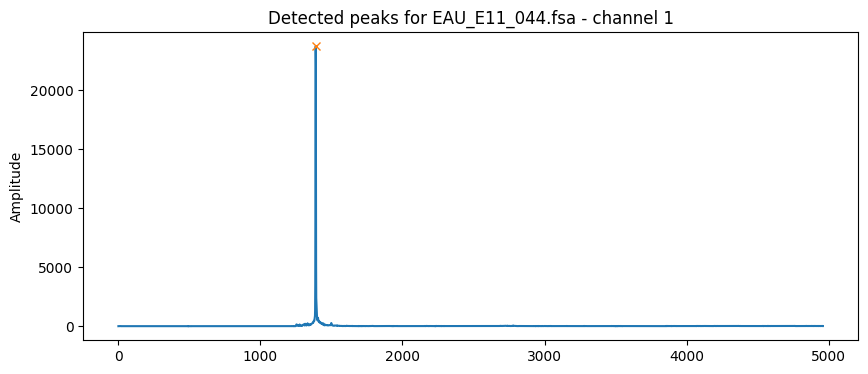

{'event_count': 1, 'mean_ipi': nan, 'std_ipi': nan, 'mean_width': np.float64(3.7438589484422664), 'mean_sharpness': np.float64(8162.0), 'mean_energy': np.float64(1654267615.0), 'mean_burst_size': nan, 'mean_burst_duration': nan}
4961


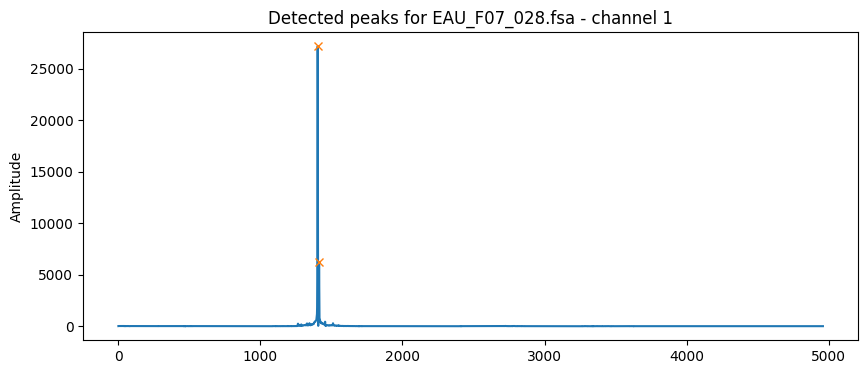

{'event_count': 2, 'mean_ipi': np.float64(10.0), 'std_ipi': np.float64(0.0), 'mean_width': np.float64(2.9681546904764673), 'mean_sharpness': np.float64(8123.5), 'mean_energy': np.float64(2015426962.5), 'mean_burst_size': np.float64(2.0), 'mean_burst_duration': np.float64(10.0)}
4961


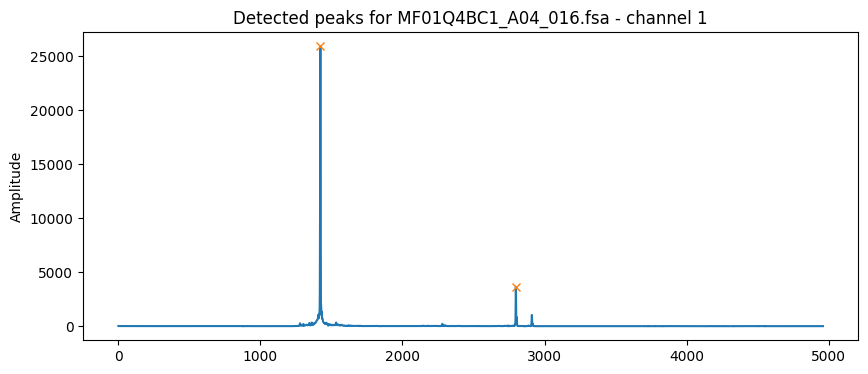

{'event_count': 2, 'mean_ipi': np.float64(1376.0), 'std_ipi': np.float64(0.0), 'mean_width': np.float64(3.5314086474407986), 'mean_sharpness': np.float64(5743.0), 'mean_energy': np.float64(989172021.5), 'mean_burst_size': np.float64(1.0), 'mean_burst_duration': nan}


In [12]:
#print(raw_dict.keys())
for plant in list(raw_dict.keys())[:3]:
    channel_1 = raw_dict[plant]['channel_1']
    features = extract_signal_features(channel_1)
    print(len(channel_1))
    peaks, _ = find_peaks(channel_1, height=2500)
    plt.figure(figsize=(10, 4))
    plt.plot(channel_1)
    plt.plot(peaks, channel_1[peaks], "x")
    plt.title(f"Detected peaks for {plant} - channel 1")
    plt.ylabel("Amplitude")
    plt.show()
    print(features)

In [13]:
pip install PyWavelets numpy


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pywt
#source : https://www.sciencedirect.com/science/article/pii/S0010482524015634#sec3
def wavelet_features(signal, wavelet='db4', level=6):
    """
    Extract wavelet features: energy, entropy, and basic stats
    from DWT coefficients at each level.

    Args:
        signal (array): Input 1D signal.
        wavelet (str): Wavelet name (db4 recommended).
        level (int): Number of decomposition levels.

    Returns:
        dict: Features across levels.
    """
    # 1) Compute discrete wavelet transform coefficients
    coeffs = pywt.wavedec(signal, wavelet, level=level)

    features = {}
    for i, c in enumerate(coeffs):
        # 2) Energy of coefficients
        energy = np.sum(c ** 2)

        # 3) Shannon entropy of coefficients
        p = (c ** 2) / energy if energy != 0 else np.zeros_like(c)
        entropy = -np.sum(p * np.log2(p + 1e-12))  # avoid log2(0)

        # 4) Basic stats on the coefficients
        features[f"level_{i}_energy"] = energy
        features[f"level_{i}_entropy"] = entropy
        features[f"level_{i}_mean"] = np.mean(c)
        features[f"level_{i}_std"] = np.std(c)

    return features
header=True
for plant in list(raw_dict.keys()):
    channel_1 = raw_dict[plant]['channel_1']
    features = wavelet_features(channel_1)
    features.to_csv("../Data/wavelet_features.csv", mode="a", header=header)
    header=False
    print(features)

Wavelet features for EAU_E11_044.fsa - channel 1:
{'level_0_energy': np.float64(194045371.88635236), 'level_0_entropy': np.float64(1.1621261625654318), 'level_0_mean': np.float64(275.2752051847943), 'level_0_std': np.float64(1494.7533282914856), 'level_1_energy': np.float64(321290234.6622213), 'level_1_entropy': np.float64(0.4875734890827061), 'level_1_mean': np.float64(212.36299584924004), 'level_1_std': np.float64(1944.167097749769), 'level_2_energy': np.float64(128874877.8222063), 'level_2_entropy': np.float64(1.197564881841959), 'level_2_mean': np.float64(-75.51310486556962), 'level_2_std': np.float64(891.4947283268671), 'level_3_energy': np.float64(475763125.0431957), 'level_3_entropy': np.float64(0.12947315500093184), 'level_3_mean': np.float64(65.80943563301767), 'level_3_std': np.float64(1225.2545155240316), 'level_4_energy': np.float64(400920858.77781355), 'level_4_entropy': np.float64(0.782650228612817), 'level_4_mean': np.float64(-28.381932728514002), 'level_4_std': np.float

In [21]:
import pandas as pd

rows = []

for plant in list(raw_dict.keys())[:50]:
    signal = raw_dict[plant]["channel_1"]

    peak_feat = extract_signal_features(signal)
    wav_feat = wavelet_features(signal)

    row = {"plant": plant}
    row.update({f"peak_{k}": v for k, v in peak_feat.items()})
    row.update({f"wavelet_{k}": v for k, v in wav_feat.items()})

    rows.append(row)

df = pd.DataFrame(rows).set_index("plant")
corr = df.corr(method="spearman")
peak_cols = [c for c in df.columns if c.startswith("peak_")]
wavelet_cols = [c for c in df.columns if c.startswith("wavelet_")]

cross_corr = corr.loc[peak_cols, wavelet_cols]
print(corr)

                          peak_event_count  peak_mean_ipi  peak_std_ipi  \
peak_event_count                  1.000000       0.086596      0.942134   
peak_mean_ipi                     0.086596       1.000000      0.124076   
peak_std_ipi                      0.942134       0.124076      1.000000   
peak_mean_width                  -0.194824       0.607817     -0.005331   
peak_mean_sharpness              -0.718660      -0.137239     -0.449476   
peak_mean_energy                  0.230463      -0.563864      0.060114   
peak_mean_burst_size             -0.184679      -0.925732     -0.137227   
peak_mean_burst_duration          0.367190       0.626499      0.344539   
wavelet_level_0_energy            0.629253      -0.172586      0.259391   
wavelet_level_0_entropy           0.019524       0.057016      0.101661   
wavelet_level_0_mean              0.618510       0.055172      0.344690   
wavelet_level_0_std               0.621919      -0.168898      0.253508   
wavelet_level_1_energy   

In [ ]:
#match features and labels


In [ ]:
# train-test split

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score

from sklearn import set_config
set_config(transform_output='pandas')

clf = RandomForestClassifier(n_estimators=10, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


print("Accuracy:", accuracy_score(y_pred, y_test))